# ***Set Parameters to define model etc***

In [1]:
#### Undersampling Strategy:#####
Undersampling = "Regular" # Options: Regular or Possoin
Sampling_Mask = "Complementary_Masks" #Options: Single_Combination or One_Mask or Complementary_Masks
AF = 3 #  acceleration factor

#### Model Input and Output ####
GT_Data = "LowRank" # Options: FullRank LowRank for GROUNDTRUTH!
Low_Rank_Input = True ## apply low rank to the input as well if True
trancuate_t = 96 # set this parameter to control at which time step you stop using the signal

####M Model Parameters ####
batch_size=64
num_convs = 10

In [2]:
import os
import sys

sys.path.append('../scripts')
sys.path.append('../models')

os.environ["CUDA_VISIBLE_DEVICES"]= '1' #, this way I would choose GPU 3 to do the work

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from data_preparation import *
from data_undersampling import *
from output_statistics import *

from interlacer_layer_modified import *
from Residual_Interlacer_modified import *
from skimage.metrics import structural_similarity as ssim 

#### Model import correct model
from Naive_CNN_3D import * #from Naive_CNN_3D_Residual_No_Batch_Norm import *

grouped_time_steps = 1 # Set how many subsequent time steps you want to give to the network at once. Values allowed: 1, 2, 4, 8 (because it has to divide 8)

In [3]:
#### Define ground truth path####
#### Define ground truth path####
if GT_Data == "FullRank":
    ground_truth_path = "../data/Ground_Truth/Full_Rank/P03-P08_truncated_k_space.npy"
elif GT_Data == "LowRank":
    ground_truth_path = "../data/Ground_Truth/Low_Rank/LR_8_P03-P08_self.npy"

#### Assemble saving path ####

#### Definie Model path
if GT_Data == "FullRank":
    saved_model_path = f"../saved_models/Naive_CNN_3D_zfT_xChannels/Full2Full/"+Undersampling+f'/AF_{AF}/'+f'Truncate_t_{trancuate_t}/'+Sampling_Mask+f'/{num_convs}Layer/best_model.pth'
elif GT_Data == "LowRank":
    saved_model_path = f"../saved_models/Naive_CNN_3D_zfT_xChannels/Low2Low/"+Undersampling+f'/AF_{AF}/'+f'Truncate_t_{trancuate_t}/'+Sampling_Mask+f'/{num_convs}Layer/best_model.pth'
    
#### Define Input Data path
undersampled_data_path = "../data/Undersampled_Data/"+Undersampling+f'/AF_{AF}/'+Sampling_Mask+'/data.npy'

#### load data
Ground_Truth = np.load(ground_truth_path)
Undersampled_Data = np.load(undersampled_data_path)

#### additionally make LowRank 8 transformation on input of network, this improves the error significantly!
if Low_Rank_Input:
    Undersampled_Data[...,0] = low_rank(Undersampled_Data[...,0], 8)
    Undersampled_Data[...,1] = low_rank(Undersampled_Data[...,1], 8)
    Undersampled_Data[...,2] = low_rank(Undersampled_Data[...,2], 8)
    Undersampled_Data[...,3] = low_rank(Undersampled_Data[...,3], 8)
    Undersampled_Data[...,4] = low_rank(Undersampled_Data[...,4], 8)
    Undersampled_Data[...,5] = low_rank(Undersampled_Data[...,5], 8)

Undersampled_Data = np.fft.fftshift(np.fft.fft(Undersampled_Data, axis=-3), axes=-3)
Ground_Truth = np.fft.fftshift(np.fft.fft(Ground_Truth, axis=-3), axes=-3)    
    
#### Data transformations !
Ground_Truth = Ground_Truth.transpose(2,3,4,0,1, 5)
Undersampled_Data = Undersampled_Data.transpose(2,3,4,0,1, 5)

In [4]:
ground_truth_train, ground_truth_test = Ground_Truth[:,:trancuate_t,:,:,:,1:6], Ground_Truth[:,:trancuate_t,:,:,:,0]  # Method: Leave last MRSI measurement as test set

#### Assign undersampled network input ####
NN_input_train, NN_input_test = Undersampled_Data[:,:trancuate_t,:,:,:,1:6], Undersampled_Data[:,:trancuate_t,:,:,:,0]

#### Collapse ununsed dimensions ####
ground_truth_train, ground_truth_test = ground_truth_train.reshape(21, trancuate_t, 8,22, -1), ground_truth_test.reshape(21, trancuate_t, 8,22, -1)
NN_input_train, NN_input_test = NN_input_train.reshape(21, trancuate_t, 8,22, -1), NN_input_test.reshape(21, trancuate_t, 8,22, -1)
#### Normalize data #####
normalized_input_train, normalized_ground_truth_train, norm_values_train = normalize_data_per_image_new(NN_input_train, ground_truth_train)
normalized_input_test, normalized_ground_truth_test, norm_values_test = normalize_data_per_image_new(NN_input_test, ground_truth_test)


#### reshape for pytorch ####
train_data, train_labels  = reshape_for_pytorch(normalized_input_train, grouped_time_steps=22), reshape_for_pytorch(normalized_ground_truth_train, grouped_time_steps=22)
test_data, test_labels = reshape_for_pytorch(normalized_input_test, grouped_time_steps=22), reshape_for_pytorch(normalized_ground_truth_test, grouped_time_steps=22)



In [5]:
#### Set parameters ####

# Create TensorDataset instances
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # Number of convolutional layers
model = Naive_CNN_3D(grouped_time_steps=22, num_convs=num_convs).to(device)

#saved_model_path = "../saved_models/Naive_CNN_3D_AF_3_Non_Residual/5Layer/model.pth"  # Replace with your file path

# 2. Load the model's state_dict (weights) from the saved file

checkpoint = torch.load(saved_model_path, map_location=device)
# Extract the model state_dict
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [6]:
model.eval()

    # List to accumulate outputs
outputs_list = []

    # Disable gradient computation for efficiency
with torch.no_grad():
    for data, _ in test_loader:
            # Move input to device
        inputs_img = data.to(device)
            
            # Forward pass (as a tuple if your model expects a tuple)
        outputs = model((inputs_img))

            # If outputs is a tuple, extract the first element
        if isinstance(outputs, tuple):
            outputs = outputs[0]

            # Store output in CPU numpy array
        outputs_list.append(outputs.cpu().numpy())

    # Concatenate all outputs
outputs_array = np.concatenate(outputs_list, axis=0)
outputs_array = inverse_reshape_for_pytorch(outputs_array, grouped_time_steps = 22)
outputs_array = denormalize_data_per_image(outputs_array, norm_values_test)
outputs_array = outputs_array.transpose(3,4,0,1,2)

Model_Outputs_Test_Set = np.fft.ifft(np.fft.ifftshift(outputs_array, axes=-2), axis=-2)

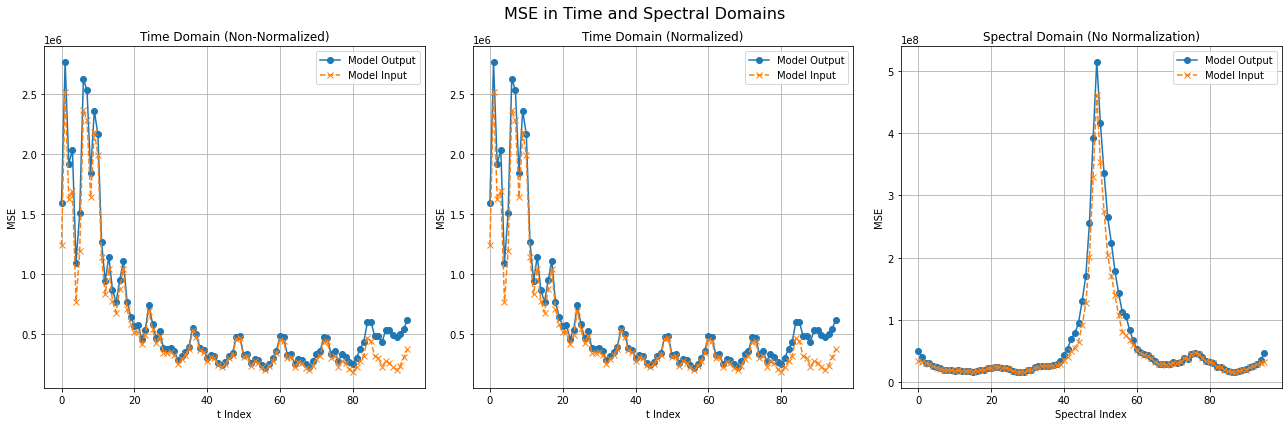

==== Model Output vs Ground Truth ====
Total MSE in image domain: 315849.2798441853
Normalized Total MSE in image domain: 315849.2798441853
Total MSE in spectral domain: 30321530.86504178

==== Model Input vs Ground Truth ====
Total MSE in image domain: 271069.9020074454
Normalized Total MSE in image domain: 271069.9020074454
Total MSE in spectral domain: 26022710.592714753


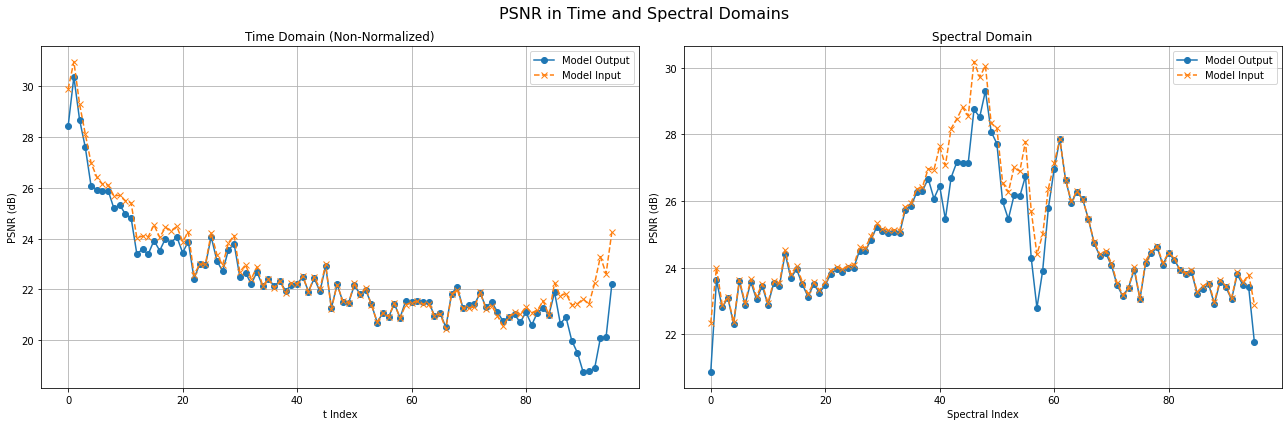

==== Model Output vs. Ground Truth ====
Average PSNR in image domain:    22.41756584092863
Average PSNR in frequency domain: 24.651905339231092

==== Model Input vs. Ground Truth ====
Average PSNR in image domain:    22.806882988088613
Average PSNR in frequency domain: 24.96728721016164


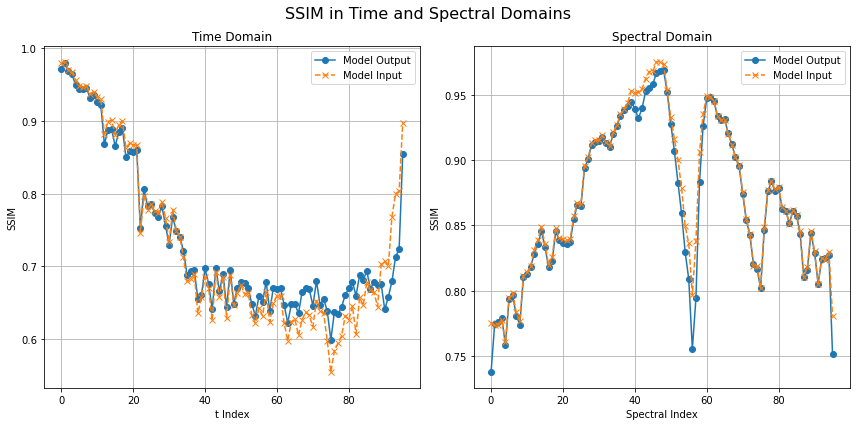

==== Model Output vs. Ground Truth ====
Average SSIM in image domain:    0.7372029195434444
Average SSIM in frequency domain: 0.867326823780771

==== Model Input vs. Ground Truth ====
Average SSIM in image domain:    0.7320668895463137
Average SSIM in frequency domain: 0.8722760064207714


In [7]:
#Model_Outputs_Test_Set, ground_truth = Process_Model_Output(test_loader, model, device, trancuate_t, 8, grouped_time_steps, norm_values_test)
Undersampled_Data = np.load(undersampled_data_path)

Undersampled_Data[...,0] = low_rank(Undersampled_Data[...,0], 8)

Ground_Truth = np.load(ground_truth_path)
ground_truth = Ground_Truth[:,:,:,:trancuate_t,:,0]

mask = np.load('../data/masks.npy')
mask_5 = mask[:,:,:,0]
mask_5D = mask_5[:,:,:, np.newaxis, np.newaxis]

Model_Outputs_Test_Set = Model_Outputs_Test_Set*mask_5D
ground_truth = ground_truth*mask_5D
norm_values_test = np.ones((trancuate_t,8))
### to be fair, I compute a LR approximation, as a trivial baseline comparison + apply the mask
model_input = Undersampled_Data[...,0]*mask_5D
model_input = model_input[:,:,:,:trancuate_t,:]

plot_general_statistics(Model_Outputs_Test_Set, model_input, ground_truth, trancuate_t, norm_values_test, label = "Model Output", label2 = "Model Input")
plot_general_statistics_PSNR(Model_Outputs_Test_Set, model_input, ground_truth, trancuate_t, norm_values_test, label = "Model Output", label2 = "Model Input")
plot_general_statistics_SSIM(Model_Outputs_Test_Set, model_input, ground_truth, trancuate_t, norm_values_test, label = "Model Output", label2 = "Model Input")

/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)
../scripts/output_statistics.py:282: RuntimeWarning: invalid value encountered in double_scalars
  return calculate_rmse(pred, gt) / (gt.max() - gt.min())


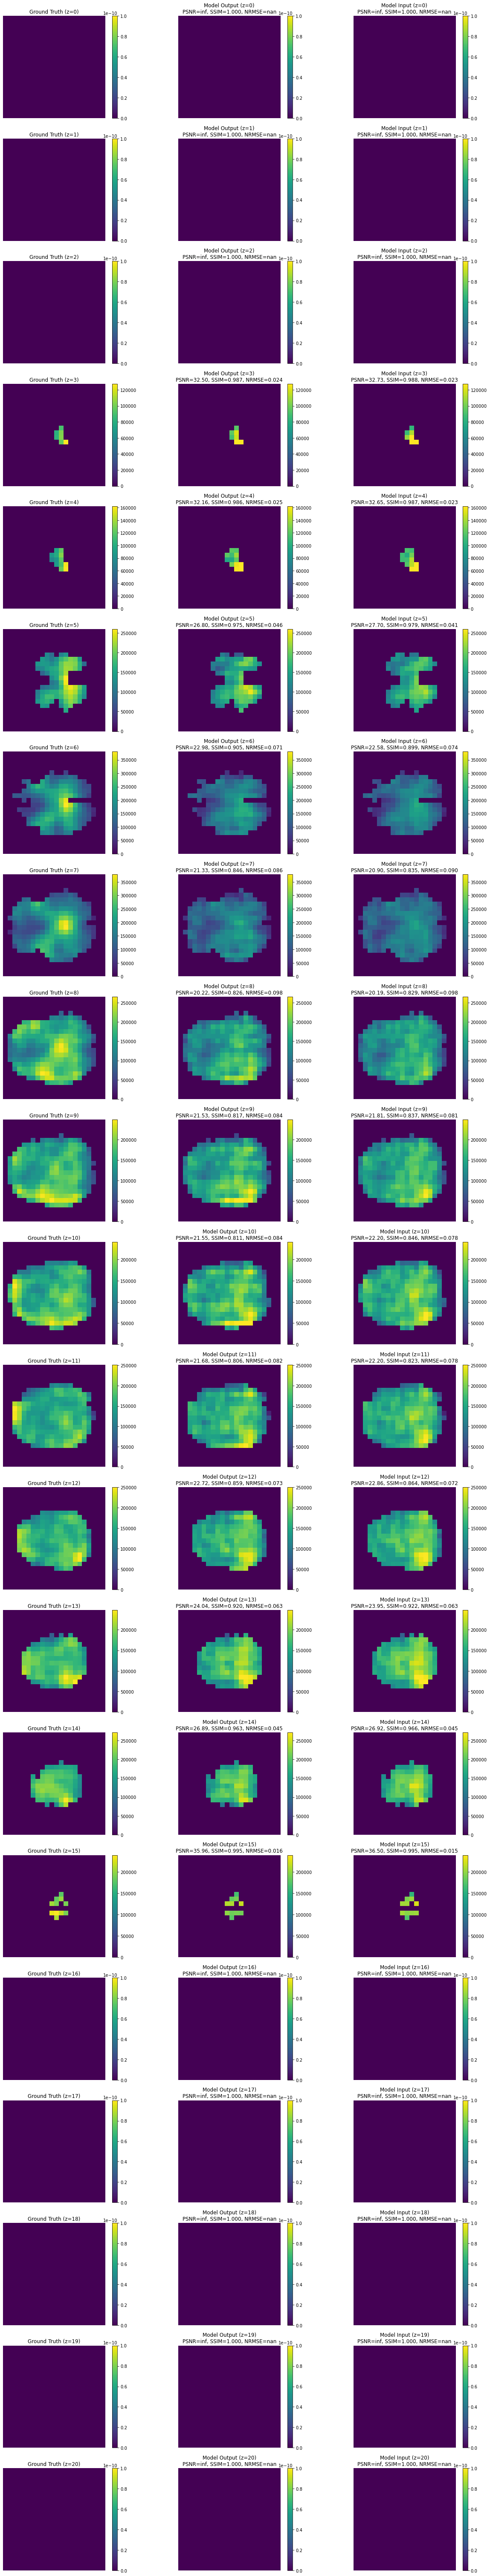

In [8]:
tf = 50 #50 = Water, 60 Glucose, 78 Glx
T = 7
comparison_Plot_3D_vs_Ifft(Model_Outputs_Test_Set, ground_truth, model_input, tf, T, domain="spectral", label = "Model Output", label2 = "Model Input")

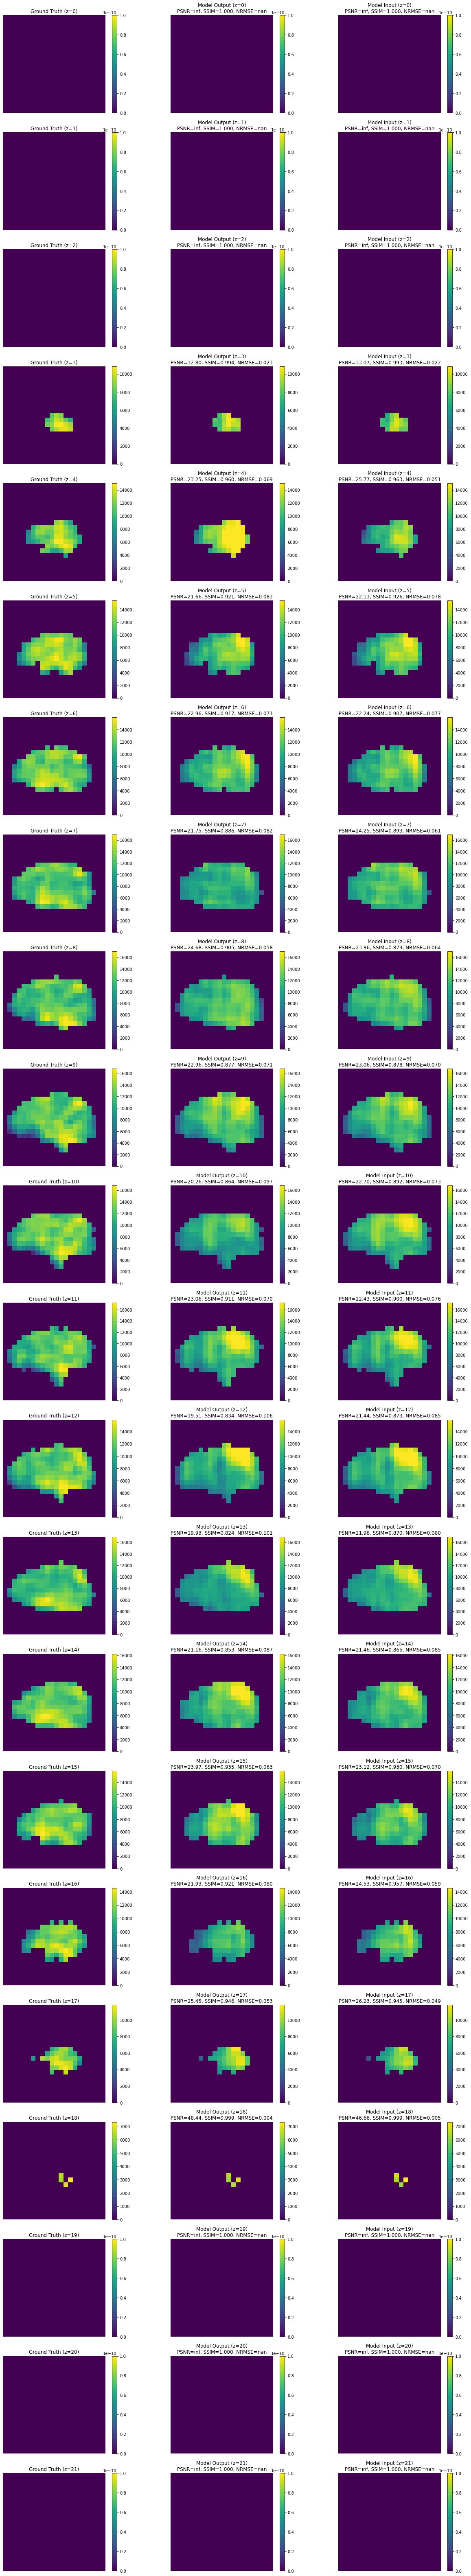

In [9]:
tf = 5 #50 = Water, 60 Glucose, 24 Glx
T = 7

### NOTE: The labels are off, due to swapping I actually show z-y images along the x axis
ground_truth_swapped = np.swapaxes(ground_truth, 0, 2)
Model_Outputs_Test_Set_swapped = np.swapaxes(Model_Outputs_Test_Set, 0, 2)
model_input_swapped = np.swapaxes(model_input, 0, 2)

comparison_Plot_3D_vs_Ifft(Model_Outputs_Test_Set_swapped, ground_truth_swapped, model_input_swapped, tf, T, domain="time", label = "Model Output", label2 = "Model Input")

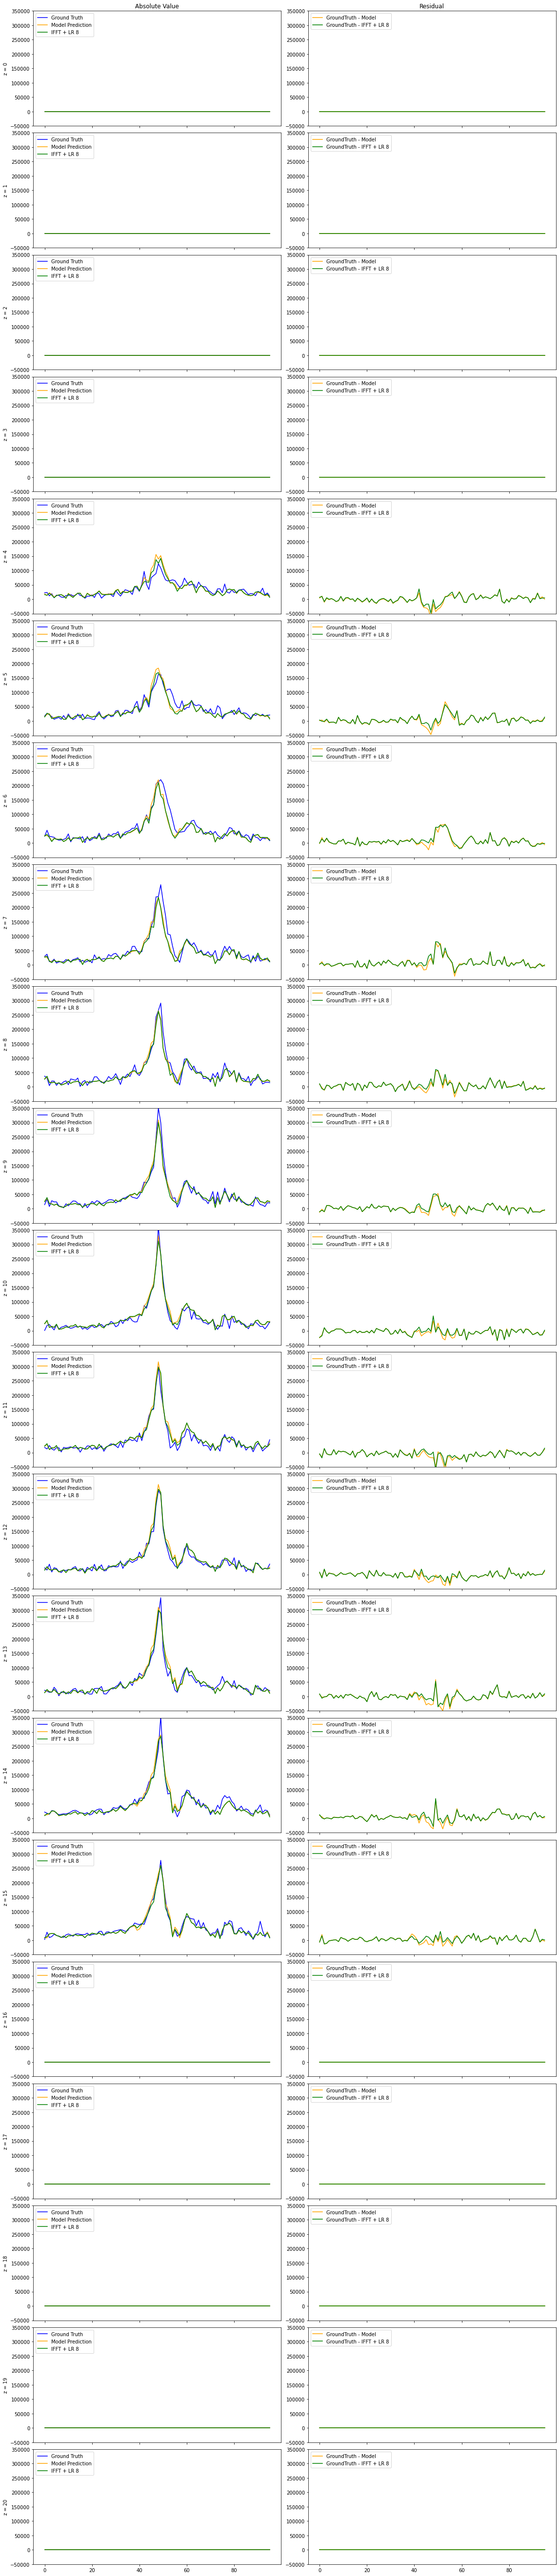

In [10]:
ground_truth_spectral = np.fft.fftshift(np.fft.fft(ground_truth, axis=-2), axes=-2)
model_pred_spectral = np.fft.fftshift(np.fft.fft(Model_Outputs_Test_Set, axis=-2), axes=-2)
IFF_LR_8 = np.fft.fftshift(np.fft.fft(model_input, axis=-2), axes=-2)

IFF_LR_8 = np.fft.fftshift(np.fft.fft(model_input, axis=-2), axes=-2)
# Fixed indices for x, y, and T:
# ----------------------------------------------------------------------
# Fixed indices for x, y, and T
# ----------------------------------------------------------------------
x_fixed = 11
y_fixed = 10
T_fixed = 7

num_z = 21  # Number of z slices

# ----------------------------------------------------------------------
# Create a figure with 2 columns:
#   Column 1 -> Absolute value plots
#   Column 2 -> Residuals (GT - [Others])
# ----------------------------------------------------------------------
fig, axes = plt.subplots(nrows=num_z, ncols=2, figsize=(16, num_z * 3.5), sharex=True)

# If there's only one row, ensure axes is 2D
if num_z == 1:
    axes = np.array([axes])

for z in range(num_z):
    # Extract the spectra at [x_fixed, y_fixed, z, :, T_fixed]
    gt_spec  = ground_truth_spectral[x_fixed, y_fixed, z, :, T_fixed]
    mp_spec  = model_pred_spectral[x_fixed, y_fixed, z, :, T_fixed]
    iff_spec = IFF_LR_8[x_fixed, y_fixed, z, :, T_fixed]
    
    # ------------------------------------------------------------------
    # Column 1: Plot absolute spectra
    # ------------------------------------------------------------------
    ax_abs = axes[z, 0]
    ax_abs.plot(np.abs(gt_spec),  label='Ground Truth',    color='blue')
    ax_abs.plot(np.abs(mp_spec),  label='Model Prediction',color='orange')
    ax_abs.plot(np.abs(iff_spec), label='IFFT + LR 8',     color='green')
    ax_abs.set_ylim(-50000, 350000)
    # Row label on the Y-axis
    ax_abs.set_ylabel(f'z = {z}')
    
    if z == 0:
        ax_abs.set_title('Absolute Value')
    ax_abs.legend(loc='upper left')
    
    # ------------------------------------------------------------------
    # Column 2: Plot residuals (Ground Truth - [Others])
    # ------------------------------------------------------------------
    ax_res = axes[z, 1]
    
    residual_gt_mp  = np.abs(gt_spec) - np.abs(mp_spec)
    residual_gt_iff = np.abs(gt_spec) - np.abs(iff_spec)
    
    ax_res.plot(residual_gt_mp,  label='GroundTruth - Model',        color='orange')
    ax_res.plot(residual_gt_iff, label='GroundTruth - IFFT + LR 8',  color='green')

    if z == 0:
        ax_res.set_title('Residual')
    ax_res.legend(loc='upper left')
    ax_res.set_ylim(-50000, 350000)
plt.tight_layout()
plt.show()


In [11]:
#### Plot error by selecting mask

# Mask = 0

# #Model_Outputs_Test_Set, ground_truth = Process_Model_Output(test_loader, model, device, trancuate_t, 8, grouped_time_steps, norm_values_test)
# Undersampled_Data = np.load(undersampled_data_path)

# Undersampled_Data[...,0] = low_rank(Undersampled_Data[...,0], 8)

# Ground_Truth = np.load(ground_truth_path)
# ground_truth = Ground_Truth[:,:,:,:trancuate_t,:,0]

# mask = np.load('../data/masks.npy')
# mask_5 = mask[:,:,:,0]
# mask_5D = mask_5[:,:,:, np.newaxis, np.newaxis]

# Model_Outputs_Test_Set = Model_Outputs_Test_Set*mask_5D
# ground_truth = ground_truth*mask_5D
# norm_values_test = np.ones((trancuate_t,8))
# ### to be fair, I compute a LR approximation, as a trivial baseline comparison + apply the mask
# model_input = low_rank(Undersampled_Data[...,0], 8)*mask_5D
# model_input = model_input[:,:,:,:trancuate_t,:]

# ### Mask application ####
# ground_truth_mask = ground_truth[:,:,:,:,Mask]
# ground_truth_mask = ground_truth_mask[..., np.newaxis]

# model_input_mask = model_input[:,:,:,:,Mask]
# model_input_mask = model_input_mask[..., np.newaxis]

# Model_Outputs_Test_Set_mask = Model_Outputs_Test_Set[:,:,:,:,Mask]
# Model_Outputs_Test_Set_mask = Model_Outputs_Test_Set_mask[..., np.newaxis]

# plot_general_statistics(Model_Outputs_Test_Set_mask, model_input_mask, ground_truth_mask, trancuate_t, norm_values_test, label = "Model Output", label2 = "Model Input")
# plot_general_statistics_PSNR(Model_Outputs_Test_Set_mask, model_input_mask, ground_truth_mask, trancuate_t, norm_values_test, label = "Model Output", label2 = "Model Input")
# plot_general_statistics_SSIM(Model_Outputs_Test_Set_mask, model_input_mask, ground_truth_mask, trancuate_t, norm_values_test, label = "Model Output", label2 = "Model Input")